# Leveraging CELLxGENE census data

This notebook was contributed by Can Ergen and Martin Kim.

Original article:
`Scvi-hub: an actionable repository for model-driven single cell analysis`

https://www.biorxiv.org/content/10.1101/2024.03.01.582887

The anndata object we're using here is a subset of the full CELLxGENE census data. Use: s3://cellxgene-contrib-public/models/scvi/2024-02-12/mus_musculus/adata_minified.h5ad

**Steps performed**:

1. Loading the minified data from AWS
2. Setting up minified model with minified data
3. Visualize the latent space
4. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import numpy as np
import scanpy as sc
import scvi
from scvi.hub import HubModel
import seaborn as sns
import torch

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IP

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 1.1.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
!aws s3 ls "s3://cellxgene-contrib-public/models/scvi/2024-02-12/homo_sapiens"

                           PRE homo_sapiens/


In [6]:
from urllib.parse import urlparse

s3_url = "s3://cellxgene-contrib-public/models/scvi/2024-02-12/homo_sapiens/model.pt"
parsed = urlparse(s3_url)

bucket = parsed.netloc
path = parsed.path.lstrip("/")

print("Bucket:", bucket)
print("Path:", path)

Bucket: cellxgene-contrib-public
Path: models/scvi/2024-02-12/homo_sapiens/model.pt


We download a toy example here (all cells from the spinal cord). To download the full census use backup_url: https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata_minified.h5ad. Expect that the download of the full census takes ~30 minutes with a high bandwidth internet connection.
We share models for mouse at https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/mus_musculus (same folder structure).

In [7]:
adata_path = os.path.join(save_dir.name, "adata-spinal-cord-minified.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata-spinal-cord-minified.h5ad",
)

model = HubModel.pull_from_s3(
    s3_bucket="cellxgene-contrib-public",
    s3_path="models/scvi/2024-02-12/homo_sapiens/modelhub",
    pull_anndata=False,
)

adata, model

100%|██████████| 45.1M/45.1M [00:02<00:00, 22.9MB/s]
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


HubModel with:
local_dir: /tmp/tmp2tfaafpk
model loaded? No
adata loaded? No
large_training_adata loaded? No
metadata:
HubMetadata(scvi_version='1.0.4', anndata_version='0.8.0', model_cls_name='SCVI', training_data_url=None, model_parent_module='scvi.model')
model_card:


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
license: cc-by-4.0                                                                                                 

library_name: scvi-tools                                                                                           

tags:                                                                                                              

 • biology                                                                                                         
 • genomics                                                                                                        
 • single-cell                                                                                                     
 • model_cls_name:SCVI                                                                                             
 • scvi_version:1.0.4                                                                                              
 • anndata_version:0.8.0                                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                   Description                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

SCVI model trained on the homo_sapiens data of the CELLxGENE Discover Census.                                      

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                Model properties                                                 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Many model properties are in the model tags. Some more are listed below.                                           

model_init_params:                                                                                                 

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
                                                                                                                   
     "n_hidden": 128,                                                                                              
                                                                                                                   
     "n_latent": 50,                                                                                               
                                                                                                                   
     "n_layers": 2,                                                                                                
                                                                                                                   
     "dropout_rate": 0.1,                                                                                          
                                                                                                                   
     "dispersion": "gene",                                                                                         
                                                                                                                   
     "gene_likelihood": "nb",                  

(AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 )

### Setup minified model

Census was trained on all primary cells. We don't encode covariates so inference and generating latent codes works without retraining on these batches. We have to subset to all training batches.

In [8]:
adata[adata.obs["is_primary_data"]]

View of AnnData object with n_obs × n_vars = 49756 × 8000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
    obsm: '_scvi_latent_qzm', '_scvi_latent_qzv'

In [10]:
del adata.uns["_scvi_adata_minify_type"]

In [11]:
# _ = adata.uns.pop('_scvi_adata_minify_type')
model.load_model(adata=adata[adata.obs["is_primary_data"]].copy())
census_model = model.model

INFO     Loading model...                                                                                          
INFO     File /tmp/tmp2tfaafpk/model.pt already downloaded                                                         


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/model/_scvi.py:155: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [12]:
census_model_all = scvi.model.SCVI.load_query_data(adata, census_model)

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 6006 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/model/_scvi.py:155: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


For spinal cord less than a half of cells is labeled as primary cells, while the other cells are duplicated from this dataset. census_model_all contains all cells while census_model only contains primary cells.

In [13]:
adata.obs["is_primary_data"].value_counts()

False    67707
True     49756
Name: is_primary_data, dtype: int64

In [14]:
census_model.adata, census_model_all.adata

(AnnData object with n_obs × n_vars = 49756 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'deve

By default scvi-tools loads models as not minified. We set up the model here with minified data, so we minify the model using the respective obsm fields.

In [15]:
census_model.minify_adata(
    use_latent_qzm_key="_scvi_latent_qzm", use_latent_qzv_key="_scvi_latent_qzv"
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


### Get the latent space and compute UMAP

2024-03-12 14:55:20.661625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 14:55:20.661650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 14:55:20.662450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 14:55:21.159238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/en

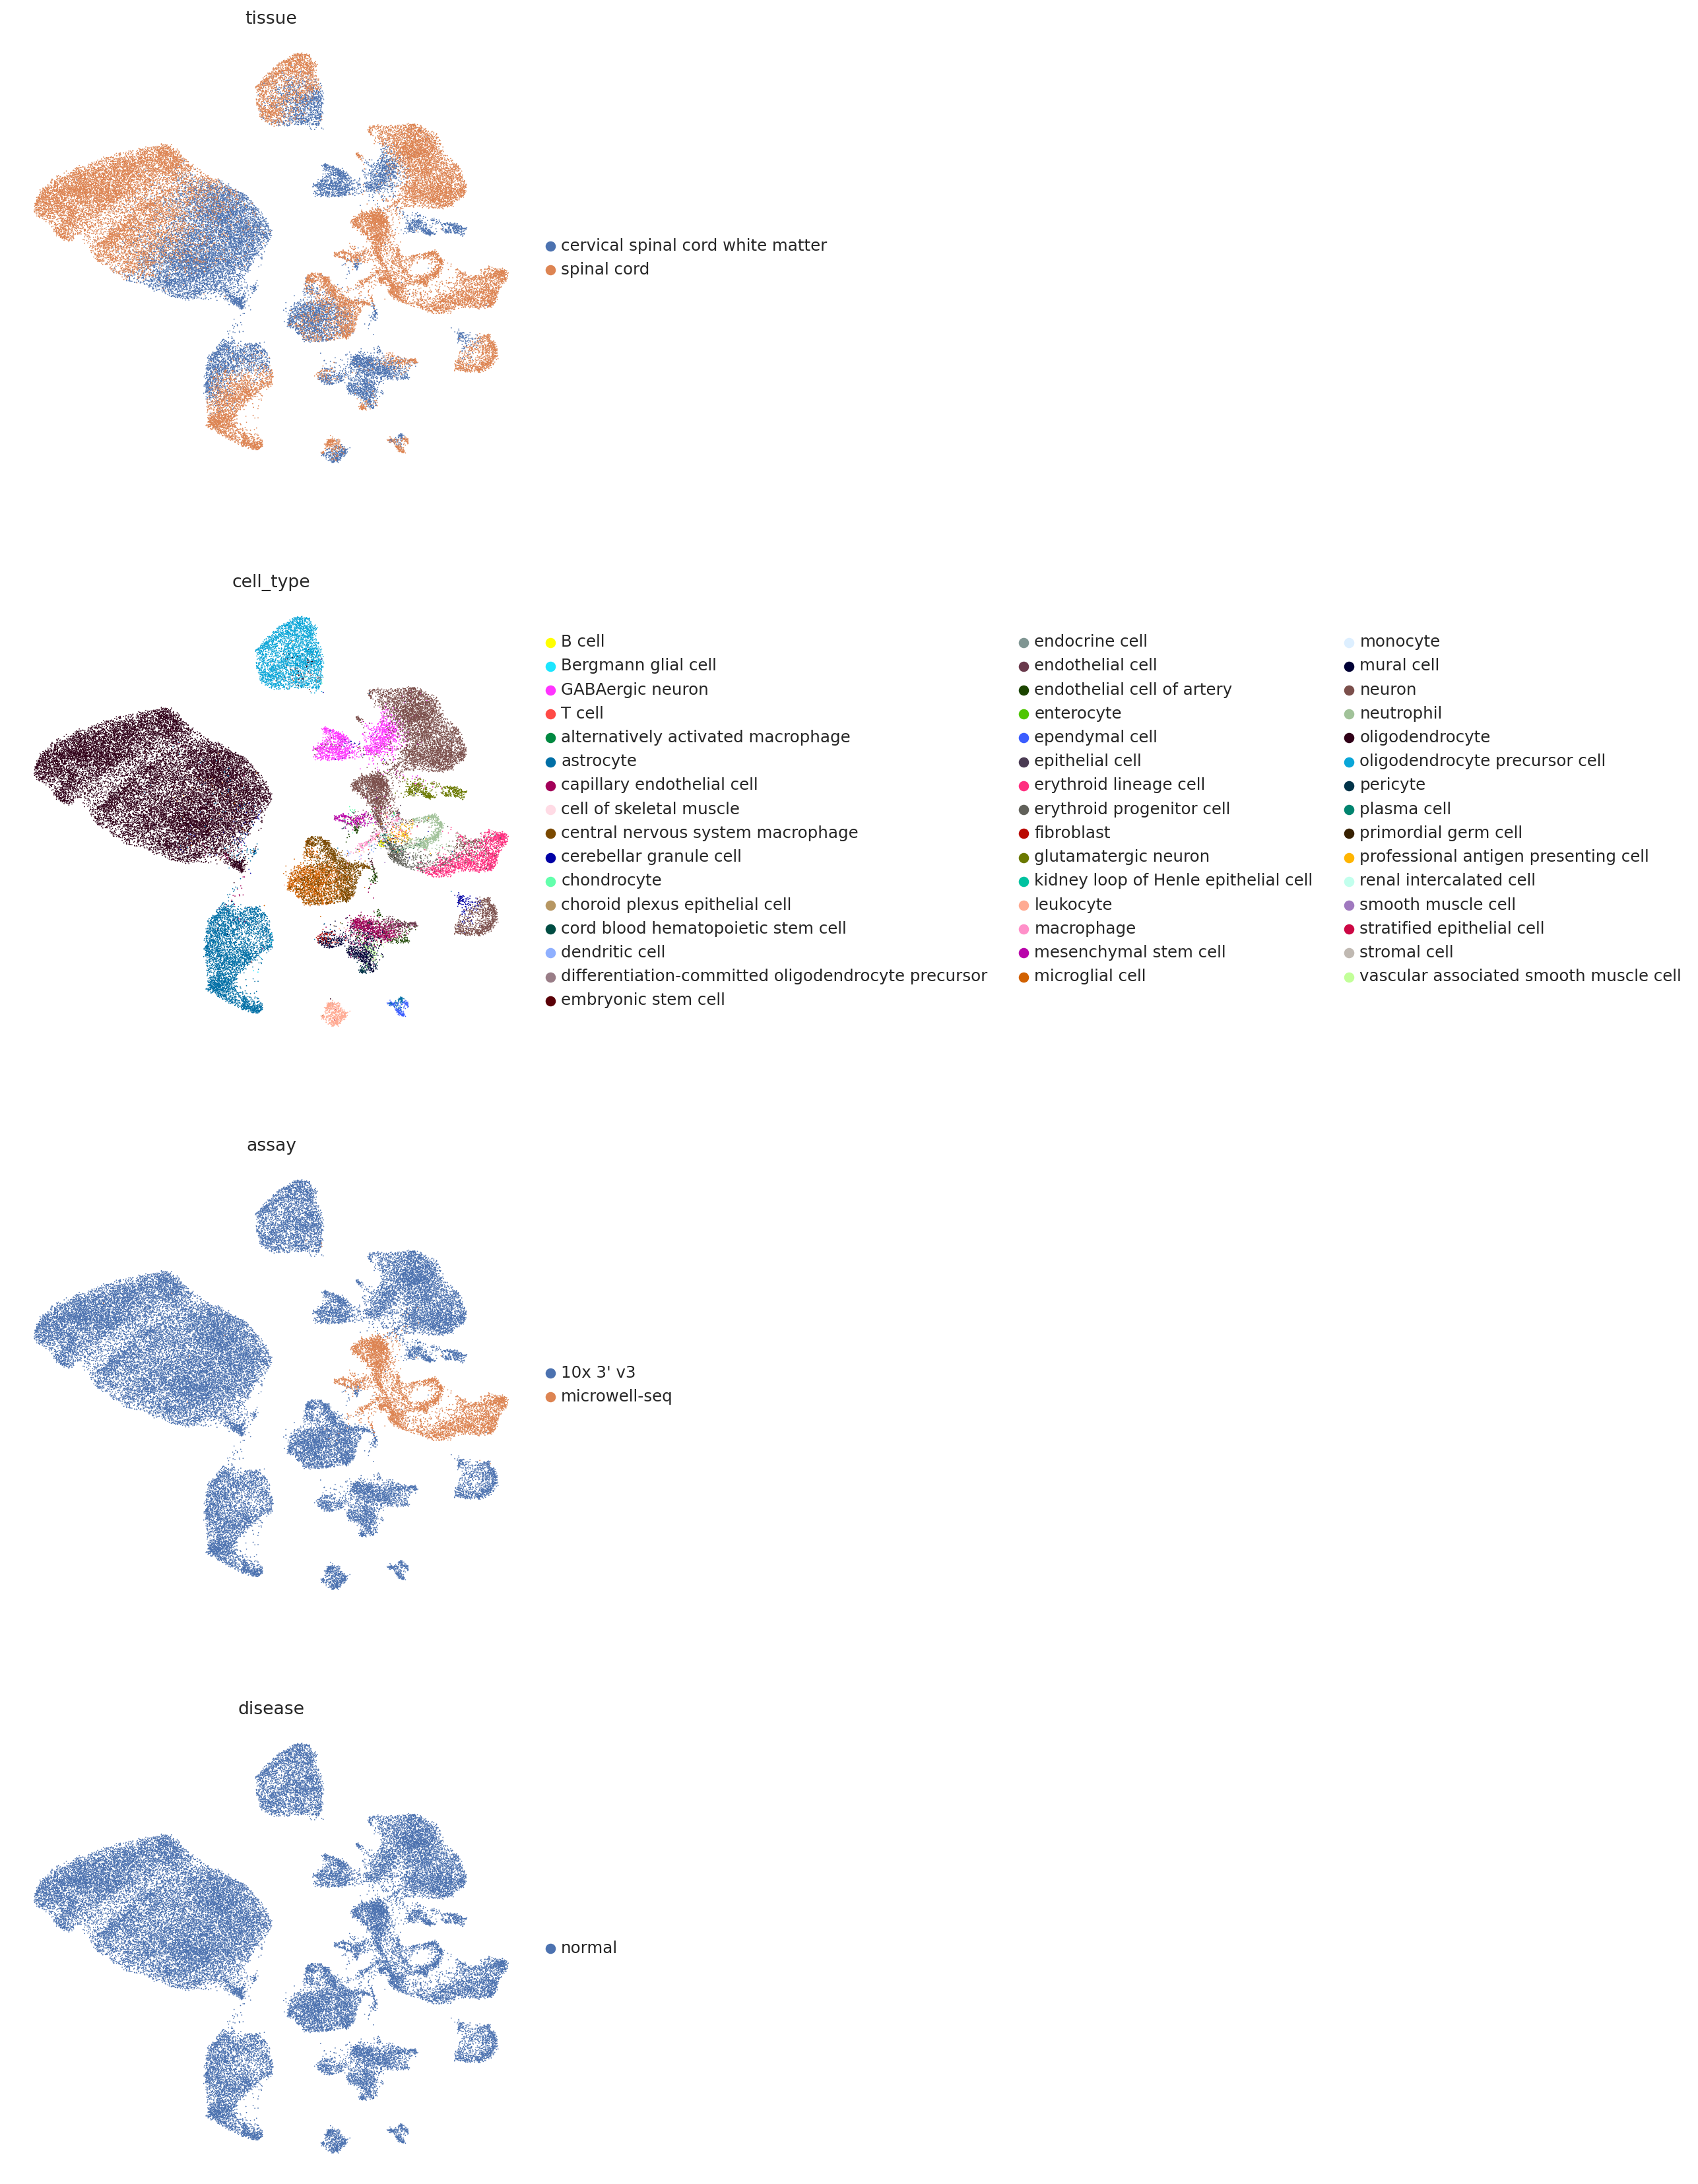

In [16]:
sc.pp.neighbors(census_model.adata, n_neighbors=20, use_rep="_scvi_latent_qzm")
sc.tl.umap(census_model.adata)
sc.pl.umap(
    census_model.adata, color=["tissue", "cell_type", "assay", "disease"], ncols=1
)

## Performing Differential Expression in scVI

While we only have access to the minified data, we can still perform downstream analysis using the generative part of the model.

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
2. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [17]:
# let's take a look at abundances of different cell types
print(
    census_model.adata.obs["cell_type"].value_counts(),
    "\n\n\n\n",
    census_model.adata.obs["tissue"].value_counts(),
)

oligodendrocyte                                        20708
neuron                                                  7831
astrocyte                                               4449
oligodendrocyte precursor cell                          3191
microglial cell                                         1864
GABAergic neuron                                        1790
central nervous system macrophage                       1777
erythroid lineage cell                                  1684
capillary endothelial cell                               915
mural cell                                               879
neutrophil                                               708
erythroid progenitor cell                                606
glutamatergic neuron                                     576
leukocyte                                                542
endothelial cell of artery                               330
endothelial cell                                         247
mesenchymal stem cell   

scVI provides several options to identify the two populations of interest.

In [18]:
cell_type = "oligodendrocyte"
tissue1 = "spinal cord"
cell_idx1 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue1,
)
print(sum(cell_idx1), "cells from tissue", tissue1)

tissue2 = "cervical spinal cord white matter"
cell_idx2 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue2,
)
print(sum(cell_idx2), "cells of type", tissue2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

11547 cells from tissue spinal cord
9161 cells of type cervical spinal cord white matter


### Basic principle

#### DE and log fold-changes

scVI can natively be used to perform differential expression analyses to compare populations of cells, as described [here](https://doi.org/10.1101/794289) and [there](https://doi.org/10.1101/2022.05.27.493625).
It achieves this by estimating the posterior distribution of the log fold-change (LFC) between subpopulations $A$ and $B$.
Specifically, for a given gene g, scVI calculates the LFC as the difference between the logarithm of its expression level in population A, denoted by $h_g^A$, and the logarithm of its expression level in population B, denoted by $h_g^B$.

The resulting value, denoted by $\beta_g$, provides insights into the expression patterns of gene $g$.
Values close to zero indicate that the gene is expressed similarly in both populations, positive values suggest upregulation in population A and negative values indicate downregulation in population A. This information can be used to better understand the biological mechanisms underlying the differences between the two cell populations.

#### DE testing

In addition to estimating the LFC, scVI can also detect which genes have *significant* expression patterns.
To tag which genes are differentially expressed, scVI tests the following competing hypotheses
$M_{1, g}: \beta_g \in [-\delta, \delta]$ and $M_{2, g}: \beta_g \in (-\infty, -\delta) \cup (\delta, \infty)$.
Here, $\delta$ denotes a small LFC threshold, such that $\beta_g \in [-\delta, \delta]$ is evidence that the gene is equally expressed in the two subpopulations.

Differentially expressed genes are identified by computing the posterior probability of $M_{2, g}$.

### Running DE analyses

#### Running and understanding a DE run

A simple DE analysis can then be performed using the following command

In [19]:
de_change = census_model.differential_expression(
    idx1=cell_idx1, idx2=cell_idx2, all_stats=False
)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

### Volcano plot of change mode DE with p-values

In [20]:
de_change["log10_pscore"] = np.log10(de_change["proba_not_de"] + 1e-6)
de_change = de_change.join(census_model.adata.var, how="inner")
de_change = de_change.loc[np.max(de_change[["scale1", "scale2"]], axis=1) > 1e-4]
de_change["feature_id"] = de_change.index
de_change.index = de_change["feature_name"]
de_change.head(20)

proba_de  proba_not_de  bayes_factor        scale1  \
feature_name                                                       
MRPL45P2           1.0           0.0     18.420681  1.238569e-04   
ZNF56              1.0           0.0     18.420681  2.484999e-04   
ZC3H11A            1.0           0.0     18.420681  4.547385e-04   
UBE2V1             1.0           0.0     18.420681  1.391494e-04   
MTRNR2L12          1.0           0.0     18.420681  2.134927e-07   
CNTNAP4            1.0           0.0     18.420681  1.275973e-05   
SNHG14             1.0           0.0     18.420681  1.230285e-03   
AC079610.1         1.0           0.0     18.420681  1.431436e-04   
RP11-156P1.3       1.0           0.0     18.420681  2.380585e-04   
ZNRD1ASP           1.0           0.0     18.420681  1.621770e-04   
MT-RNR2            1.0           0.0     18.420681  1.070539e-03   
MT-RNR1            1.0           0.0     18.420681  1.805790e-04   
MRPS31P5           1.0           0.0     18.420681  1.029055e-04   
MIR100HG           1.0           0.0     18.420681  2.157358e-03   
MAGI2-AS3          1.0           0.0     18.420681  4.455178e-04   
PANTR1             1.0           0.0     18.420681  2.099369e-04   
EIF1B-AS1          1.0           0.0     18.420681  2.956051e-04   
FAHD2CP            1.0           0.0     18.420681  2.061842e-04   
IQCJ-SCHIP1        1.0           0.0     18.420681  1.631556e-06   
EEF1G              1.0           0.0     18.420681  1.003616e-04   

                    scale2  pseudocounts  delta   lfc_mean  lfc_median  \
feature_name                                                             
MRPL45P2      1.813690e-07           0.0   0.25   9.536882    9.517754   
ZNF56         1.219989e-07           0.0   0.25  11.130910   11.137473   
ZC3H11A       1.021392e-04           0.0   0.25   2.192004    2.145333   
UBE2V1        8.504062e-06           0.0   0.25   4.084165    4.086322   
MTRNR2L12     1.378975e-04           0.0   0.25  -9.673748   -9.738552   
CNTNAP4       3.214964e-03           0.0   0.25  -7.929339   -7.918542   
SNHG14        3.918743e-07           0.0   0.25  11.876549   11.898840   
AC079610.1    1.563228e-06           0.0   0.25   6.612420    6.558994   
RP11-156P1.3  2.327634e-07           0.0   0.25  10.204658   10.211931   
ZNRD1ASP      1.121968e-05           0.0   0.25   3.913165    3.830692   
MT-RNR2       3.471010e-07           0.0   0.25  11.501528   11.356797   
MT-RNR1       1.180232e-07           0.0   0.25  10.434817   10.314936   
MRPS31P5      9.414825e-08           0.0   0.25  10.208504   10.180031   
MIR100HG      2.144453e-05           0.0   0.25   6.733041    6.717414   
MAGI2-AS3     2.453916e-07           0.0   0.25  11.038156   11.028936   
PANTR1        5.634894e-06           0.0   0.25   5.294738    5.297277   
EIF1B-AS1     2.835490e-07           0.0   0.25  10.235081   10.240375   
FAHD2CP       9.028895e-08           0.0   0.25  11.325483   11.325918   
IQCJ-SCHIP1   6.501428e-04           0.0   0.25  -8.605043   -8.564031   
EEF1G         6.922848e-07           0.0   0.25   7.309297    7.353211   

               lfc_std    lfc_min    lfc_max  is_de_fdr_0.05  log10_pscore  \
feature_name                                                                 
MRPL45P2      0.688708   7.477606  12.135914            True          -6.0   
ZNF56         0.687035   9.006168  13.543782            True          -6.0   
ZC3H11A       0.447081   0.717063   4.240174            True          -6.0   
UBE2V1        0.452624   2.505405   5.501104            True          -6.0   
MTRNR2L12     2.136936 -16.653496  -2.571272            True          -6.0   
CNTNAP4       0.750654 -14.577003  -1.207595            True          -6.0   
SNHG14        0.956206   8.628953  14.992356            True          -6.0   
AC079610.1    0.796138   4.353514  10.104455            True          -6.0   
RP11-156P1.3  0.794538   7.782669  12.797055            True          -6.0   
ZNRD1ASP      0.477830   2.692

In [21]:
gene_annotations = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "gene_biotype"],
)

In [22]:
gene_annotations.index = gene_annotations["ensembl_gene_id"]
gene_annotation_dict = gene_annotations["gene_biotype"].to_dict()
de_change["Biotype"] = [
    gene_annotation_dict.pop(i, "Unannotated") for i in de_change["feature_id"]
]
de_change["Biotype"].value_counts()

protein_coding                        814
lncRNA                                 72
transcribed_unprocessed_pseudogene      7
Unannotated                             2
Mt_rRNA                                 2
transcribed_unitary_pseudogene          1
Name: Biotype, dtype: int64

In [23]:
import plotnine as p9

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


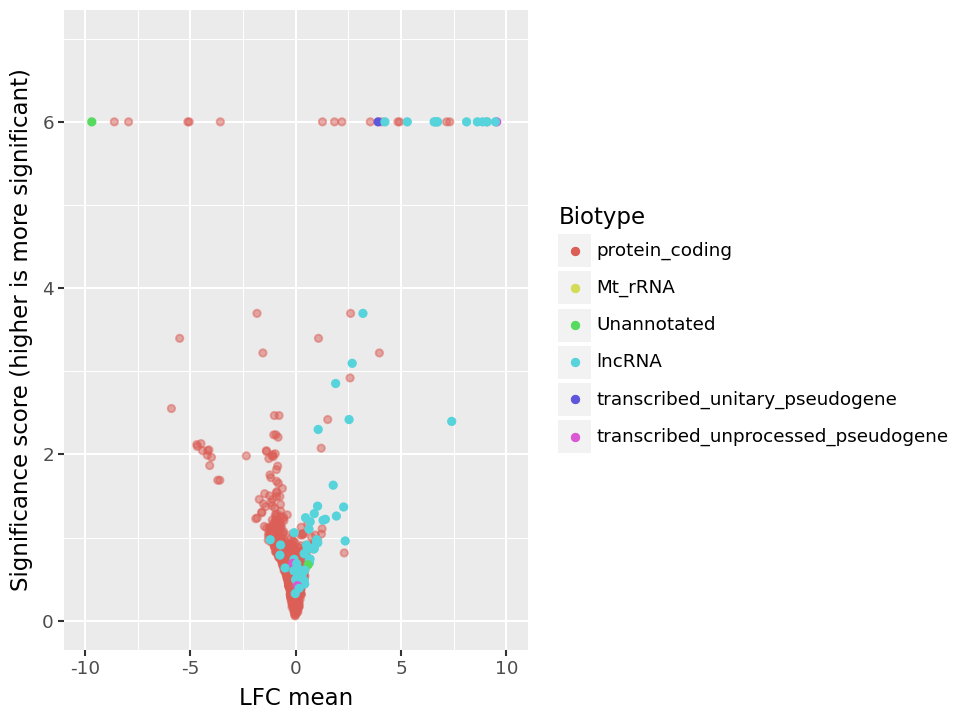

In [24]:
(
    p9.ggplot(de_change, p9.aes("lfc_mean", "-log10_pscore", color="Biotype"))
    + p9.geom_point(
        de_change.query("Biotype == 'protein_coding'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.xlim(-10, 10)  # Set x limits
    + p9.ylim(0, 7)  # Set y limits
    + p9.geom_point(de_change.query("Biotype != 'protein_coding'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
)

In [45]:
upregulated_genes = de_change.loc[
    de_change["lfc_median"] > 0, ["feature_id", "feature_name"]
].head(4)

soma_joinid    feature_name  feature_length      nnz  \
feature_id                                                              
ENSG00000233576            0         HTR3C2P            1057    69370   
ENSG00000268895            2        A1BG-AS1            3374  3071864   
ENSG00000175899            4             A2M            6318  7894261   
ENSG00000166535            6           A2ML1            7156  2156616   
ENSG00000114771           14           AADAC            1632   552258   
...                      ...             ...             ...      ...   
ENSG00000267793        60364    RP11-576C2.1             570     1544   
ENSG00000287694        60475    RP11-58C22.1            5454  2438547   
ENSG00000288546        60522     RP11-40F8.2            1135  4682350   
ENSG00000288560        60533    RP1-236J16.2            1303   730034   
ENSG00000288630        60611  RP11-231C14.10            1723   158316   

                 n_measured_obs  
feature_id                       
ENSG00000233576        19581263  
ENSG00000268895        61946057  
ENSG00000175899        62704378  
ENSG00000166535        60911688  
ENSG00000114771        54941618  
...                         ...  
ENSG00000267793        12167875  
ENSG00000287694        13464401  
ENSG00000288546        12430934  
ENSG00000288560        12430934  
ENSG00000288630          238149  

[8000 rows x 5 columns]

Display generated counts from scVI model

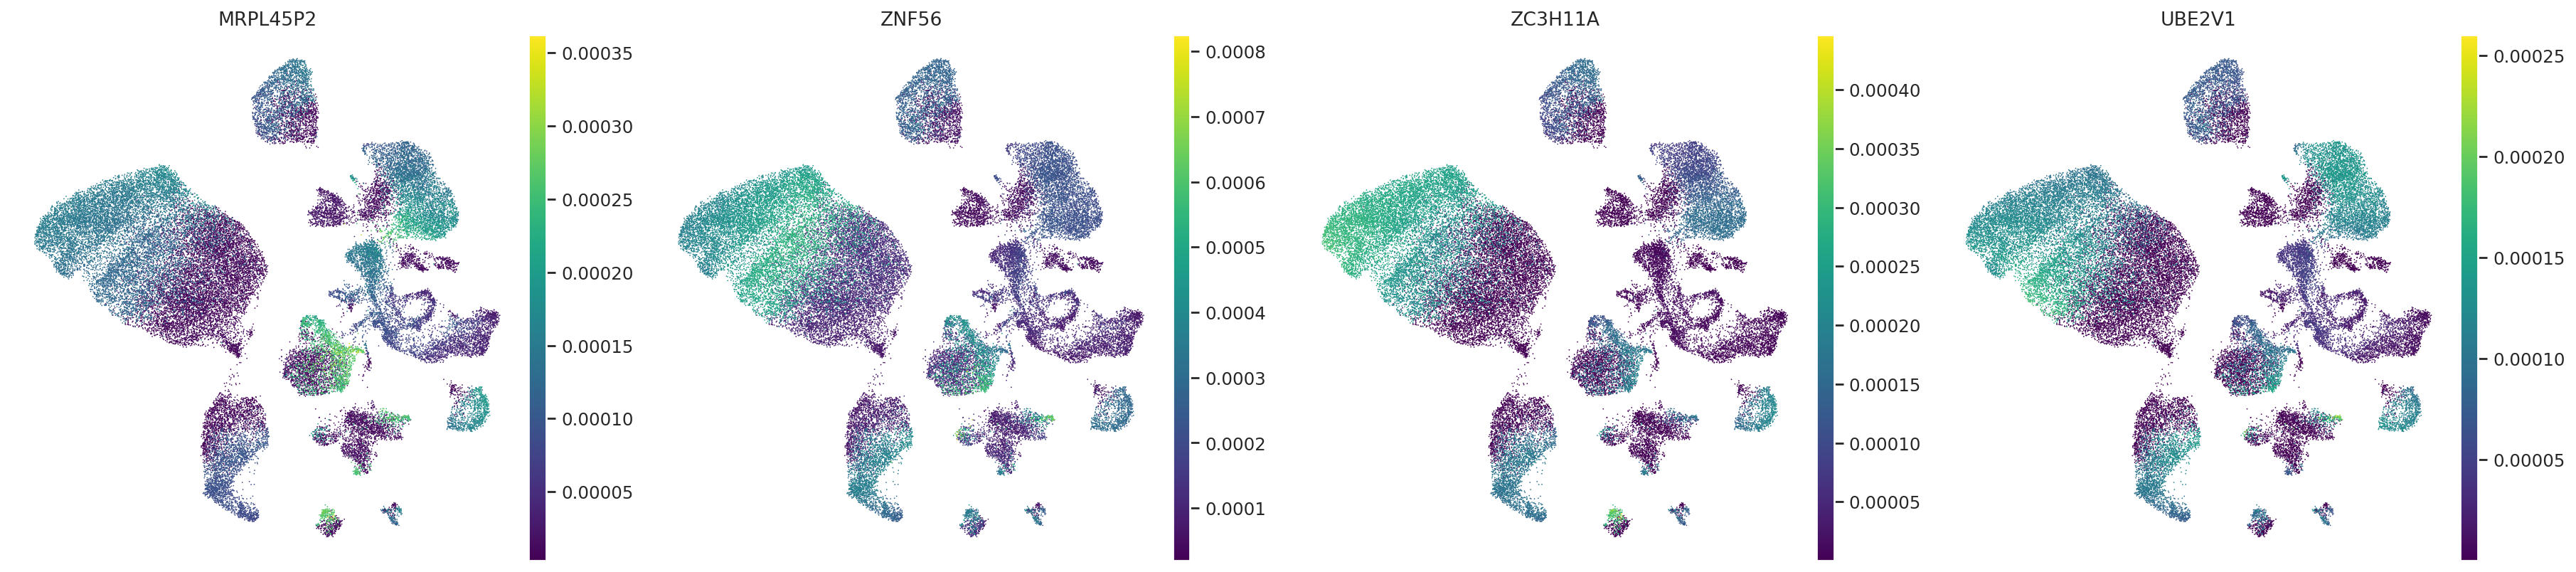

In [52]:
census_model.adata[
    :, upregulated_genes["feature_id"]
] = census_model.get_normalized_expression(
    gene_list=list(upregulated_genes["feature_id"]), n_samples=10
)
sc.pl.umap(
    census_model.adata,
    color=upregulated_genes["feature_name"],
    gene_symbols="feature_name",
    cmap="viridis",
)

Contrary to the `uniform` flavor, the `importance` flavor returns sharper posterior probability scores (posterior probability near 0 or 1, respectively in case of equal expression or differential expression).

### Heatmap of top expressed genes

Now we perform DE between each cell type vs all other cells and make a heatmap of the result.

In [25]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1 vs all results, contained in a DataFrame
change_per_cluster_de = census_model.differential_expression(
    adata=census_model.adata[census_model.adata.obs["assay"] == "10x 3' v3"],
    groupby="cell_type",
    all_stats=False,
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...:   0%|          | 0/21 [00:00<?, ?it/s]

DE...: 100%|██████████| 21/21 [00:55<00:00,  2.65s/it]


We focus on cell-types with at least 500 cells, and which have annotations to facilitate heatmap visualization

In [26]:
change_per_cluster_de

proba_de  proba_not_de  bayes_factor        scale1  \
feature_id                                                            
ENSG00000287372    0.9950        0.0050      5.293303  3.524976e-04   
ENSG00000287544    0.9950        0.0050      5.293303  3.130992e-04   
ENSG00000104518    0.9942        0.0058      5.144079  2.185148e-05   
ENSG00000213934    0.9940        0.0060      5.109976  4.513291e-10   
ENSG00000134817    0.9938        0.0062      5.076985  6.242274e-05   
...                   ...           ...           ...           ...   
ENSG00000134077    0.5536        0.4464      0.215227  6.661419e-05   
ENSG00000014824    0.5474        0.4526      0.190171  2.771000e-04   
ENSG00000155008    0.5112        0.4888      0.044807  1.250871e-04   
ENSG00000147601    0.5006        0.4994      0.002400  1.907441e-04   
ENSG00000156928    0.4768        0.5232     -0.092867  9.705371e-05   

                       scale2  pseudocounts  delta   lfc_mean  lfc_median  \
feature_id                                                                  
ENSG00000287372  5.209113e-05           0.0   0.25  10.096865    9.775373   
ENSG00000287544  1.226643e-05           0.0   0.25   9.772115    8.158090   
ENSG00000104518  3.339110e-05           0.0   0.25   1.591792    2.424228   
ENSG00000213934  9.797597e-08           0.0   0.25  -6.296728   -6.229402   
ENSG00000134817  5.507724e-05           0.0   0.25   4.710623    5.534523   
...                       ...           ...    ...        ...         ...   
ENSG00000134077  6.172174e-05           0.0   0.25   0.117607    0.115292   
ENSG00000014824  2.963776e-04           0.0   0.25  -0.109207   -0.096463   
ENSG00000155008  1.207153e-04           0.0   0.25   0.053401    0.074978   
ENSG00000147601  1.824224e-04           0.0   0.25   0.057992    0.071241   
ENSG00000156928  9.217017e-05           0.0   0.25   0.070690    0.064281   

                  lfc_std    lfc_min    lfc_max  is_de_fdr_0.05  \
feature_id                                                        
ENSG00000287372  4.151770  -4.090694  17.649317            True   
ENSG00000287544  4.616457  -2.396123  19.937347            True   
ENSG00000104518  2.441474  -4.735933   6.004245            True   
ENSG00000213934  3.042470 -16.691236   6.936626            True   
ENSG00000134817  3.480687  -6.570769  11.634119            True   
...                   ...        ...        ...             ...   
ENSG00000134077  0.414835  -1.317038   1.710752           False   
ENSG00000014824  0.410851  -1.683020   1.262657           False   
ENSG00000155008  0.372652  -1.397919   1.350549           False   
ENSG00000147601  0.359308  -1.210853   1.511045           False   
ENSG00000156928  0.367758  -1.218220   1.378252           False   

                                                     comparison  \
feature_id                                                        
ENSG00000287372                     Bergmann glial cell vs Rest   
ENSG00000287544                     Bergmann glial cell vs Rest   
ENSG00000104518                     Bergmann glial cell vs Rest   
ENSG00000213934                     Bergmann glial cell vs Rest   
ENSG00000134817                     Bergmann glial cell vs Rest   
...                                                         ...   
ENSG00000134077  vascular associated smooth muscle cell vs Rest   
ENSG00000014824  vascular associated smooth muscle cell vs Rest   
ENSG00000155008  vascular associated smooth muscle cell vs Rest   
ENSG00000147601  vascular associated smooth muscle cell vs Rest   
ENSG00000156928  vascular associated smooth muscle cell vs Rest   

                                                 group1 group2  
feature_id                                                      
ENSG00000287372                     Bergmann glial cell   Rest  
ENSG00000287544                     Bergmann glial cell   Rest  
ENSG00000104518                     Bergmann glial cell   Rest  
ENSG00000213934       

In [27]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [30]:
change_per_cluster_de = change_per_cluster_de.join(census_model.adata.var, how="inner")
change_per_cluster_de = change_per_cluster_de[
    change_per_cluster_de[["scale1", "scale2"]].max(axis=1) > 1e-4
]

In [31]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

## Download raw counts for these genes from CELLxGENE census

It is important to use the same census version used for training the model

In [32]:
import cellxgene_census

In [33]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

In [34]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

In [35]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="Homo sapiens",
    var_coords=marker_genes["soma_joinid"].to_list(),
    obs_coords=census_model.adata.obs.loc[
        census_model.adata.obs["assay"] == "10x 3' v3", "soma_joinid"
    ].to_list(),
    column_names={
        "obs": [
            "soma_joinid",
            "dataset_id",
            "assay",
            "cell_type",
            "disease",
            "donor_id",
            "observation_joinid",
            "sex",
            "suspension_type",
            "tissue",
            "raw_sum",
            "nnz",
            "raw_mean_nnz",
            "raw_variance_nnz",
            "n_measured_vars",
        ]
    },
)

[2024-03-12 14:57:54.684] [tiledbsoma] [Process: 301258] [Thread: 303641] [warning] [TileDB-SOMA::ManagedQuery] [<DataFrame 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (open for 'r')> reader] Invalid column selected: observation_joinid


Check that census download yields the same cells

In [36]:
adata.var.index = adata.var["feature_id"]

In [37]:
np.all(
    adata.obs["dataset_id"].values
    == census_model.adata.obs.loc[
        census_model.adata.obs["assay"] == "10x 3' v3", "dataset_id"
    ]
)

True

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


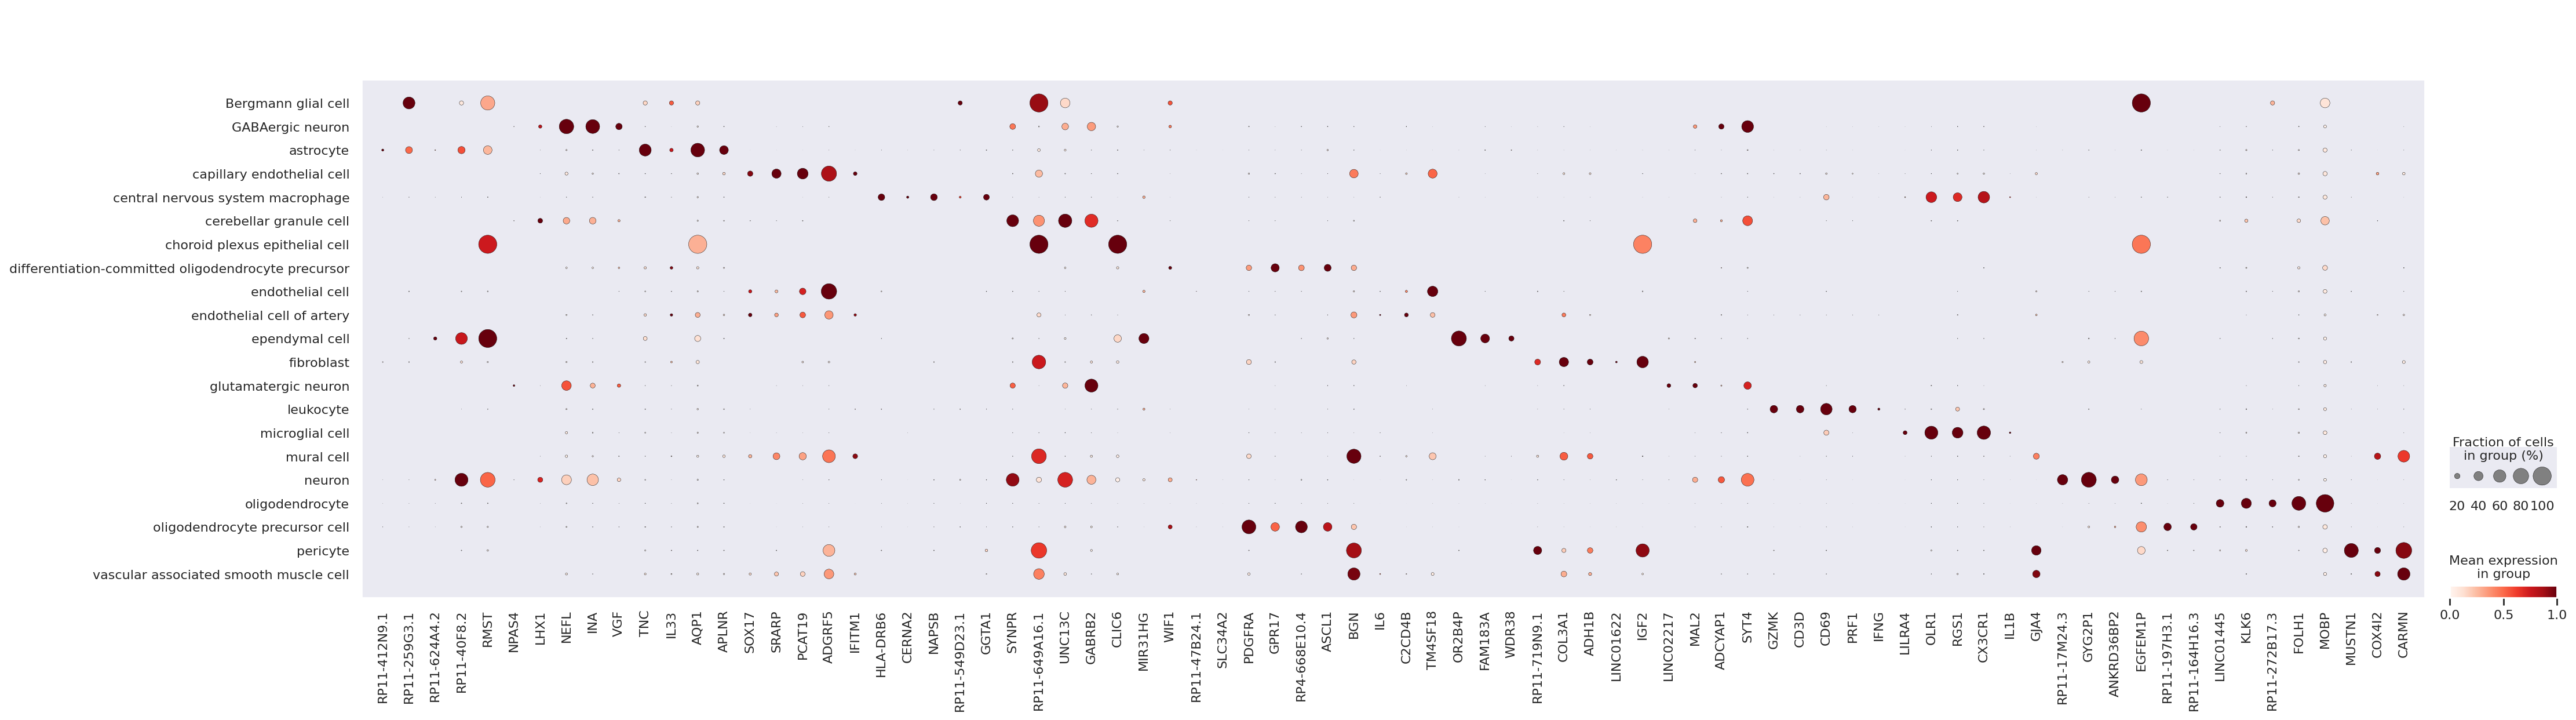

In [38]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(
    adata_log,
    marker_genes["feature_name"].to_list(),
    groupby="cell_type",
    gene_symbols="feature_name",
    standard_scale="var",
)